In [1]:
%load_ext dotenv
%dotenv

In [2]:
import ast
import os
import re
import string
import time
import pandas as pd
import nusacrowd as nc
import openai
import matplotlib.pyplot as plt
from dateutil.parser import parse
from pathlib import Path
from tqdm import tqdm
from google.cloud import translate

In [3]:
dset = nc.load_datasets([
    'nusaparagraph_topic'
])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
openai.api_key = os.environ['OPENAI_API_KEY']
openai.organization = os.environ['OPENAI_UILAB_KEY']

In [5]:
out_parent_dir = "../dataset/concept_extraction/"
model_name = "gpt-3.5-turbo"
resp_history_filename = f"{out_parent_dir}{model_name}_history_230831.csv"

In [6]:
ent_types = ['person', 'location', 'occupation', 'activity', 'cult_event', 'hist_event', 'food', 'custom']

In [7]:
resp_history_path = Path(resp_history_filename)
if resp_history_path.is_file():
    print("Response history found!")
    resp_history_df = pd.read_csv(resp_history_filename, converters={'response': lambda x: ast.literal_eval(x)})
    response_history = dict(zip(resp_history_df.prompt, resp_history_df.response))
    first_key = next(iter(response_history))
    print(response_history[first_key])
    print(type(response_history[first_key]))
else:
    print("Response history not found. Initializing new one...")
    print(resp_history_filename)
    response_history = {}

Response history found!
{'person': '', 'location': 'kostan, tempat', 'occupation': 'padamelan, kateteran, pagawean', 'activity': 'nyanyanyian, jalan-jalan', 'cult_event': '', 'hist_event': '', 'food': '', 'custom': ''}
<class 'dict'>


In [8]:
def get_input_prompt(text, lang_name):
    start_prompt = f"""Extract the important entities mentioned in the text below. 
Extract all historical figure names (HIST_FIGURE), all location names (LOC), all occupation names (OCC), all seasonal/cultural/religious activity (ACT), all cultural event names (CULT-EVT), all historical event names (HIST-EVT), all food names (FOOD), and all Indonesian-related law or custom such as wearing helmets for motorbike riders, receiving with right hand, eating with hands, etc (CUST). Please strictly follow the desired output below. Extracted 'custom' (CUST) must be answered in {lang_name} language.

Desired format:
HIST_FIGURE: <comma_separated_list_of_historical_figure_names>
LOC: -||-
OCC: -||-
ACT: -||-
CULT-EVT: -||-
HIST-EVT: -||-
FOOD: -||-
CUST: -||-

Text:"""

    return f"{start_prompt} {text}"

In [9]:
def get_openai_chat_completion(input_prompt, model_name):
    return openai.ChatCompletion.create(
        model=model_name,
        messages=[
            {
                'role': 'user',
                'content': input_prompt
            }
        ],
        temperature=0.3
    )


def get_openai_concepts(input_prompt, model_name):
    if input_prompt in response_history:
        return response_history[input_prompt]
    
    try:
        completion = get_openai_chat_completion(input_prompt, model_name)
    except Exception:
        print('Caught exception, wait for 1 min...')
        time.sleep(60)
        completion = get_openai_chat_completion(input_prompt, model_name)

    response = completion.choices[0].message.content.strip()   
    responses = [r for r in response.split('\n') if r != '']
    responses = [re.sub(r'^.*:', '', resp).strip() for resp in responses]
    if len(responses) != 8:
        print(response)
    assert len(responses) == 8 or response.count('-||-') == 8
    response_final = {}
    for ent_type, resp in zip(ent_types, responses):
        if resp in ['-||-', '-']:
            response_final[ent_type] = ''
        else:
            response_final[ent_type] = resp
    
    response_history[input_prompt] = response_final
    resp_history_df = pd.DataFrame({'prompt': response_history.keys(), 'response': response_history.values()})
    resp_history_df.to_csv(resp_history_filename, index=False)
    
    return response_final

In [10]:
dset_names = [
    'nusaparagraph_topic_sun_nusantara_text',
    'nusaparagraph_topic_btk_nusantara_text',
    'nusaparagraph_topic_bew_nusantara_text',
    'nusaparagraph_topic_bug_nusantara_text',
    'nusaparagraph_topic_jav_nusantara_text',
    'nusaparagraph_topic_mad_nusantara_text',
    'nusaparagraph_topic_mak_nusantara_text',
    'nusaparagraph_topic_min_nusantara_text',
    'nusaparagraph_topic_mui_nusantara_text',
    'nusaparagraph_topic_rej_nusantara_text',
]

topics = [
    "food & beverages", "sports", "leisures", "religion", "culture & heritage",
    "slice of life", "technology", "business"
]

In [11]:
concepts_data = {
    'text': [], 'topic': [],
    'person': [], 'location': [], 'occupation': [], 'activity': [],
    'cult_event': [], 'hist_event': [], 'food': [], 'custom': []
}
dset_sun = dset['nusaparagraph_topic_sun_nusantara_text']
for split in ['test']:
    for sample in tqdm(dset_sun[split]):
        topic = topics[sample['label']]
        if topic in ['business', 'technology']:
            continue
        
        input_prompt = get_input_prompt(sample['text'], 'Sundanese')
        concepts = get_openai_concepts(input_prompt, model_name)

        if all([v == "" or v == "-" for v in concepts.values()]):
            continue
        
        for k, v in concepts.items():
            concepts_data[k].append(v)
        
        concepts_data['text'].append(sample['text'])
        concepts_data['topic'].append(topic)

100%|██████████| 900/900 [00:00<00:00, 32855.56it/s]


In [12]:
concepts_df = pd.DataFrame(concepts_data)

In [13]:
concepts_df

,text,topic,person,location,occupation,activity,cult_event,hist_event,food,custom
0,Mipit nyaeta salah sahiji acara adat anu kagia...,culture & heritage,,,,,,,"sangu congcot, sirih lengkep, endog hayam, pis...",Mipit nyaeta upacara bubuka atawa pangjajap me...
1,Salah sahiji kabeungharan Indonesia nyaeta sen...,culture & heritage,,"Indonesia, nusantara",,"tatanen, moro",,,,
2,"Peryogi kauninga, dina hal ieu réa pisan béja ...",sports,,stadion,suporter,tanding,,,,
3,"Aya sababaraha mangpaat tari Jaipong, nyaeta b...",culture & heritage,,Jaipong,,,,,,
4,Renang oge salah sahiji hobi urang salian ti n...,leisures,,Hotel Oasis Siliwangi,,,,,,
...,...,...,...,...,...,...,...,...,...,...
472,Alesan kadua naha urang kedah gancang ngakuan ...,slice of life,,"gunung, leuweung","pendaki, panyakit gunung, tim SAR",,,,,
473,"Lamun keur libur sakola, baheula abdi sareng r...",leisures,,"Gunung Manglayang, Batu Kuda, Cibiru",,,,,,
474,Udang saos Padang nyaeta kadaharan anu dijieun...,food & beverages,,"Kota Padang, Sumatera Barat, Indonesia",,,,,"Udang saos Padang, sambel Padang",
475,Kabupaten Subang jadi salah sahiji daerah anu ...,leisures,,"Kabupaten Subang, Subang selatan, Lembang Band...",,,,,,


In [14]:
dset_name_out = 'nusaparagraph_topic_sun_nusantara_text'.replace('_nusantara_text', '')
concepts_df.to_csv(f"{out_parent_dir}{dset_name_out}_test_concepts.csv", index=False)

In [15]:
def is_date(string, fuzzy=True):
    try: 
        parse(string, fuzzy=fuzzy)
        return True

    except ValueError:
        return False

In [16]:
concepts_by_topic = []
for index, row in concepts_df.iterrows():
    for ent_type in ent_types:
        if ent_type == 'custom' and (row[ent_type] == row['text'] or len(row[ent_type].split('. ')) >= 2):
            continue

        cons = row[ent_type].split(', ')
        for c in cons:
            if all([tok in string.punctuation for tok in re.sub("\d+", "", c).strip().split()]):
                continue

            concept_cleaned = c.lower() if c[-1] not in string.punctuation else c.lower()[:-1]
            concept_cleaned = re.sub("[\(\[].*?[\)\]]", "", concept_cleaned)
            concept_cleaned = re.sub("[\(\[].*", "", concept_cleaned).strip()

            if (concept_cleaned not in row['text'].lower() and ent_type != 'custom') or len(concept_cleaned) <= 1:
                continue

            if is_date(concept_cleaned) and ent_type not in ['cult_event', 'hist_event']:
                continue 

            concepts_by_topic.append({
                'concept': concept_cleaned,
                'type': ent_type,
                'topic': row['topic'],
                'text_source': row['text']
            })

In [17]:
concepts_by_topic_df = pd.DataFrame(concepts_by_topic).drop_duplicates(['concept', 'type', 'topic']).sort_values(['topic', 'text_source']).reset_index(drop=True)

In [18]:
concepts_by_topic_df

,concept,type,topic,text_source
0,karajaan sunda,location,culture & heritage,"ANGKLUNG, nyaéta pakakas musik tradisional asl..."
1,jasinga,location,culture & heritage,"ANGKLUNG, nyaéta pakakas musik tradisional asl..."
2,bogor,location,culture & heritage,"ANGKLUNG, nyaéta pakakas musik tradisional asl..."
3,upacara melak padi,activity,culture & heritage,"ANGKLUNG, nyaéta pakakas musik tradisional asl..."
4,nyembah dewi sri pohaci,activity,culture & heritage,"ANGKLUNG, nyaéta pakakas musik tradisional asl..."
...,...,...,...,...
1497,malaysia,location,sports,Waktu keur leutik mah resep pisan lalajo Tufik...
1498,pamaen badminton,occupation,sports,Waktu keur leutik mah resep pisan lalajo Tufik...
1499,kajuaraan dunia,activity,sports,Waktu keur leutik mah resep pisan lalajo Tufik...
1500,gunung padang,location,sports,Zaman ayeuna mah seueur wahana wisata nu diada...


In [19]:
concepts_by_topic_df.to_csv(f"{out_parent_dir}{dset_name_out}_test_concepts_nusa_topic.csv", index=False)

In [20]:
def get_topic_mapping(ent_type):
    if ent_type == 'location':
        return 'places'
    
    if ent_type == 'food':
        return 'food'
    
    if ent_type in ['person', 'hist_event']:
        return 'history'

    if ent_type in ['activity', 'occupation', 'cult_event']:
        return 'activity'

    if ent_type == 'custom':
        return 'custom'

    return 'others'

In [21]:
def translate_texts(texts, project_id="id-csqa", src_lang="su", tgt_lang="en"):

    client = translate.TranslationServiceClient()
    location = "global"
    parent = f"projects/{project_id}/locations/{location}"

    response = client.translate_text(
        request={
            "parent": parent,
            "contents": texts,
            "mime_type": "text/plain",
            "source_language_code": src_lang,
            "target_language_code": tgt_lang,
        }
    )

    return [t.translated_text for t in response.translations]

In [26]:
csqa_concepts = []
for item in tqdm(concepts_by_topic):
    csqa_topic = get_topic_mapping(item['type'])
    csqa_concepts.append({
        'concept': item['concept'],
        'concept_en': translate_texts([item['concept']])[0],
        'category': csqa_topic,
        'nusa_topic': item['topic'],
        'text_source': item['text_source']
    })

100%|██████████| 1863/1863 [29:54<00:00,  1.04it/s]


In [27]:
concepts_by_csqa_topic_df = pd.DataFrame(csqa_concepts).drop_duplicates(['concept', 'category']).sort_values(['category', 'nusa_topic', 'text_source']).reset_index(drop=True)

In [28]:
concepts_by_csqa_topic_df

,concept,concept_en,category,nusa_topic,text_source
0,upacara melak padi,rice planting ceremony,activity,culture & heritage,"ANGKLUNG, nyaéta pakakas musik tradisional asl..."
1,nyembah dewi sri pohaci,worship the goddess Sri Pohaci,activity,culture & heritage,"ANGKLUNG, nyaéta pakakas musik tradisional asl..."
2,bandit,bandits,activity,culture & heritage,Abdi ti Jakarta. Salah sahiji legenda Betawi a...
3,nelayan,fisherman,activity,culture & heritage,Acara Adat Nadran di Indramayu-Cirebon anu bia...
4,pamayang,fisherman,activity,culture & heritage,Acara Adat Nadran di Indramayu-Cirebon anu bia...
...,...,...,...,...,...
1352,bengkel,workshop,places,sports,Unggal Minggu isuk-isuk Jaja sok ngurilingan k...
1353,madrid,Madrid,places,sports,Waktu keur leutik mah resep pisan lalajo Tufik...
1354,kuala lumpur,Kuala Lumpur,places,sports,Waktu keur leutik mah resep pisan lalajo Tufik...
1355,malaysia,Malaysia,places,sports,Waktu keur leutik mah resep pisan lalajo Tufik...


In [29]:
concepts_by_csqa_topic_df.to_csv(f"{out_parent_dir}{dset_name_out}_test_concepts_csqa.csv", index=False)

In [30]:
category_counts = concepts_by_csqa_topic_df['category'].value_counts()

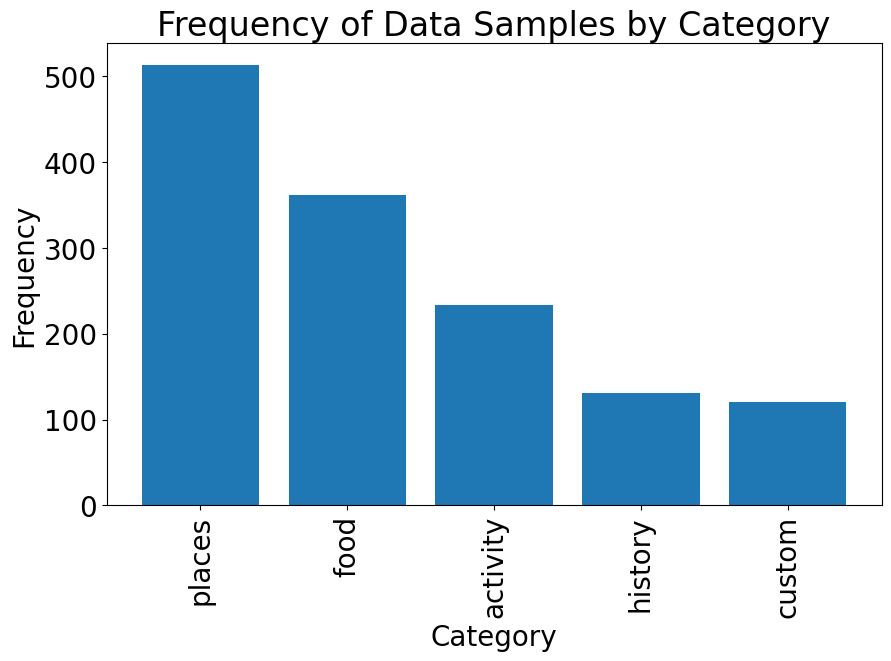

In [31]:
plt.rc('font', size=20)
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Frequency of Data Samples by Category')
plt.xticks(rotation=90)  # Rotate x-axis labels if necessary
plt.show()

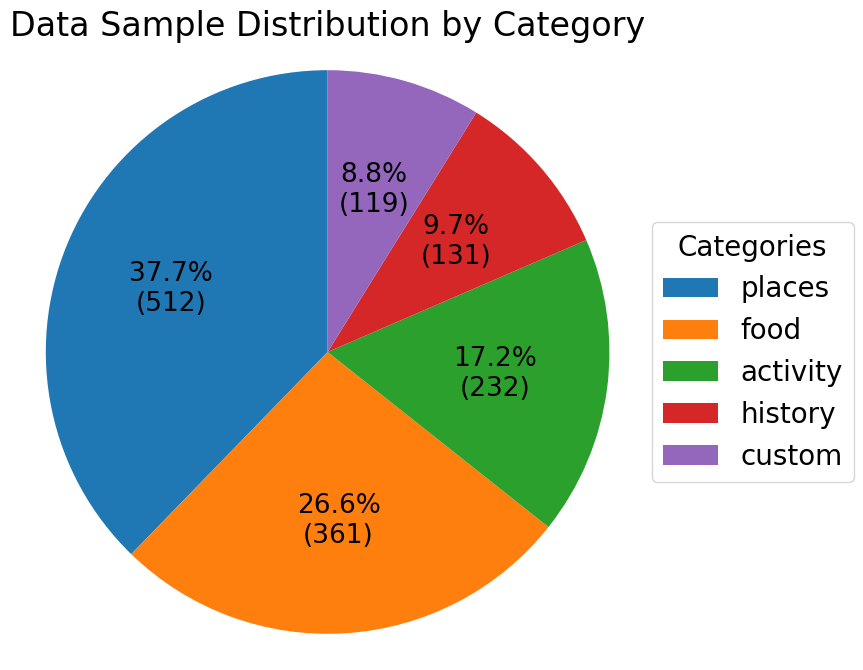

In [32]:
plt.figure(figsize=(8, 8)) 
data = category_counts.values
labels = category_counts.index
total = sum(data)

# Format the percentage and total data count in the autopct label
def func(pct):
    absolute = int(pct/100.*total)
    return f"{pct:.1f}%\n({absolute})"

plt.pie(data, autopct=func, startangle=90, textprops={'fontsize': 19})
plt.title(f'Data Sample Distribution by Category')

plt.legend(labels, title="Categories", loc="center left", bbox_to_anchor=(1, 0.5))

plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.
plt.show()